In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas
!pip install pysheds
!pip install mplleaflet
!pip install IPython
!pip install simplekml

     |████████████████████████████████| 972kB 17.7MB/s 
     |████████████████████████████████| 6.5MB 54.9MB/s 
     |████████████████████████████████| 14.8MB 204kB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 19.1MB 170kB/s 
  Created wheel for pysheds: filename=pysheds-0.2.7-cp36-none-any.whl size=51838 sha256=5ea46951429bac88b0be7dcf418e69f639448147dec2996c02a801951073f991
  Stored in directory: /root/.cache/pip/wheels/e4/87/6f/f67cbfbc39ea2c76e0cb801c37590b9e3c47e9eee7baea2547
Successfully built pysheds
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-cp36-none-any.whl size=28555 sha256=41cf97e37edc45d7f541804979f1e80c9891c0bdf139311ac12f118eee5256a2
  Stored in directory: /root/.cache/pip/wheels/bf/fd/0b/0513de62c339c4a56e2234aa42a5d06e6660a4446fdae7b796
Successfully built mplleaflet
     |████████████████████████████████| 71kB 8.9MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
from pyproj import CRS
%matplotlib inline
from IPython.display import IFrame


In [ ]:
grid = Grid.from_raster('/content/drive/MyDrive/DEM/m_idukki1.tif', data_name='dem')

In [ ]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    # plt.imshow(data, cmap=cmap)

    plt.colorbar(label=label)
    plt.grid()

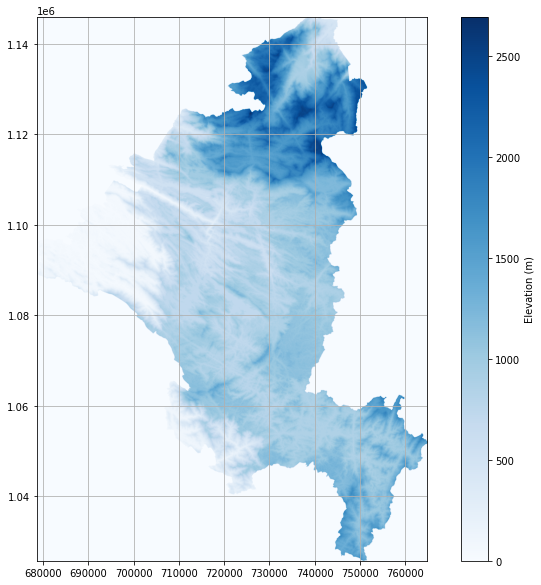

In [ ]:
plotFigure(grid.dem, 'Elevation (m)')

In [ ]:
depressions = grid.detect_depressions('dem')


Text(0.5, 1.0, 'Depressions')

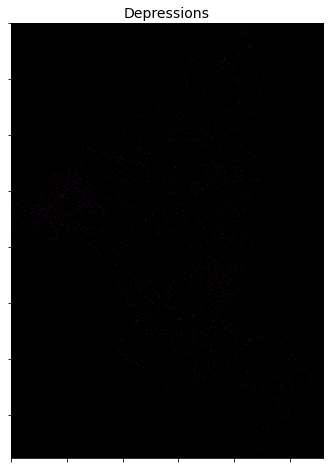

In [ ]:

# Plot pits
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(depressions, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Depressions', size=14)

In [ ]:
grid.fill_depressions(data='dem', out_name='flooded_dem')


In [ ]:
flats = grid.detect_flats('flooded_dem')


Text(0.5, 1.0, 'Flats')

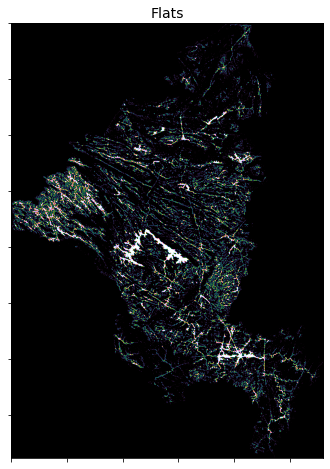

In [ ]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [ ]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')


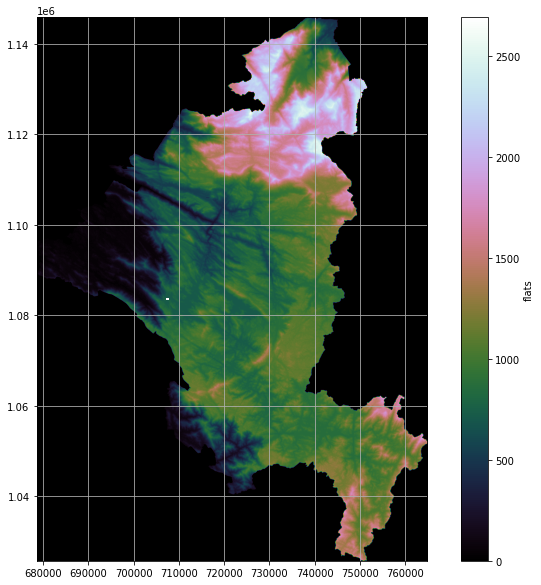

In [ ]:
plotFigure(grid.inflated_dem, 'flats', 'cubehelix')

In [ ]:
flats_test = grid.detect_flats('inflated_dem')


Text(0.5, 1.0, 'Flats')

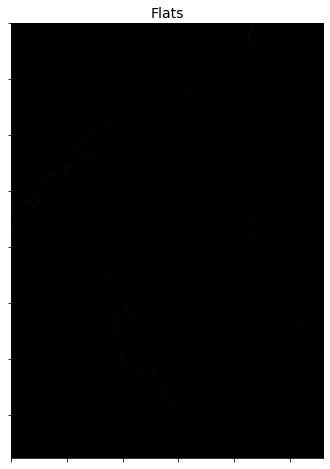

In [ ]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats_test, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [ ]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [ ]:
# Compute flow direction based on corrected DEM
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)


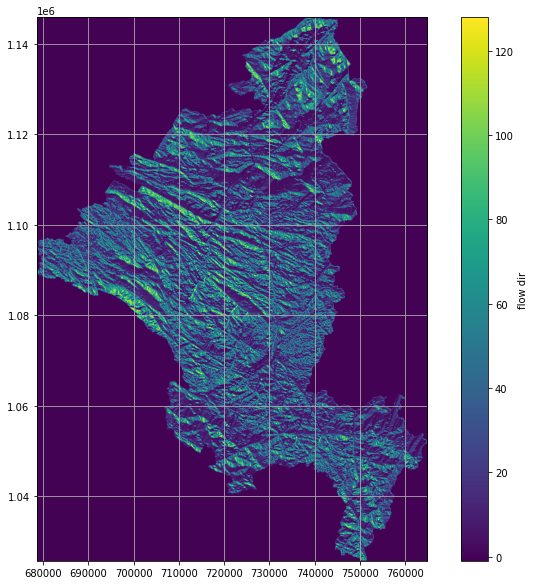

In [ ]:
plotFigure(grid.dir , 'flow dir', 'viridis')

In [ ]:
# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

In [ ]:
# import pyproj

# # Compute areas of each cell in new projection
# new_crs = pyproj.Proj('+init=epsg:3083')
# areas = grid.cell_area(as_crs=new_crs, inplace=False)

# # Weight each cell by its relative area
# weights = (areas / areas.max()).ravel()

# # Compute accumulation with new weights
# grid.accumulation(data='dir', weights=weights, out_name='acc')

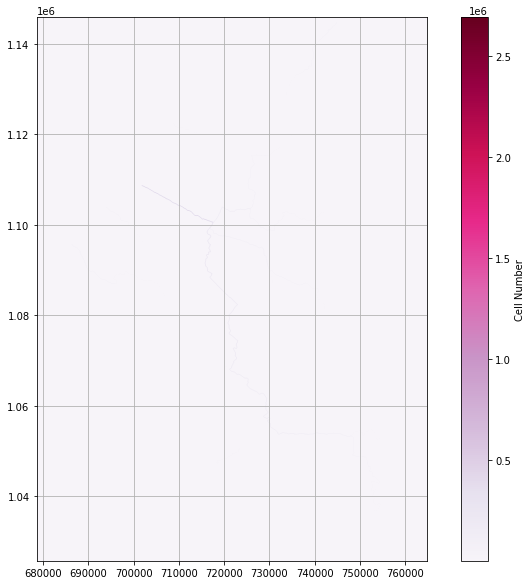

In [ ]:
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

In [ ]:
# Delineate catchment at point of high accumulation
y, x = np.unravel_index(np.argsort(grid.acc.ravel())[-2], grid.acc.shape)
grid.catchment(x, y, data='dir', out_name='catch',
               dirmap=dirmap, xytype='index')


In [ ]:
streams = grid.extract_river_network('catch', 'acc', threshold=1000, dirmap=dirmap)
streams["features"][:2]

[{"geometry": {"coordinates": [[742115.664338, 1123427.843373], [742084.805948, 1123458.701763], [742053.947558, 1123489.560153], [742053.947558, 1123520.418543], [742053.947558, 1123551.276933], [742053.947558, 1123582.135322], [742053.947558, 1123612.993712], [742023.089169, 1123643.852102], [742023.089169, 1123674.710492], [741992.230779, 1123705.568882], [741992.230779, 1123736.427272], [741961.372389, 1123767.285661], [741930.513999, 1123798.144051], [741930.513999, 1123829.002441], [741899.655609, 1123859.860831], [741868.797219, 1123890.719221], [741837.93883, 1123921.577611], [741807.08044, 1123921.577611], [741776.22205, 1123952.436], [741745.36366, 1123952.436], [741714.50527, 1123952.436], [741683.64688, 1123952.436], [741652.78849, 1123952.436], [741621.930101, 1123983.29439], [741591.071711, 1124014.15278], [741560.213321, 1124045.01117], [741529.354931, 1124075.86956], [741498.496541, 1124106.72795], [741467.638151, 1124137.58634], [741436.779762, 1124168.444729], [741405

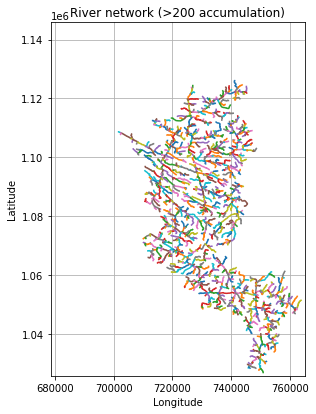

In [ ]:
fig, ax = plt.subplots(figsize=(6.5,6.5))

plt.grid('on', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network (>200 accumulation)')
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for stream in streams['features']:
    line = np.asarray(stream['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

In [ ]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [ ]:
#save geojson as separate file
saveDict(streams,'streams.geojson')

In [ ]:
streamNet = gpd.read_file('streams.geojson')
# streamNet.crs = {'init' :'epsg:32613'}
streamNet.crs = CRS('epsg:32613')

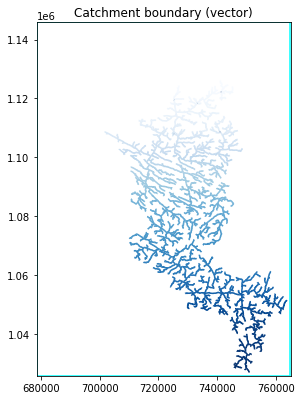

In [ ]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

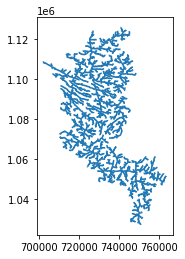

In [ ]:
ax = streamNet.plot()


In [ ]:
mplleaflet.display(fig=ax.figure , epsg=32613)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

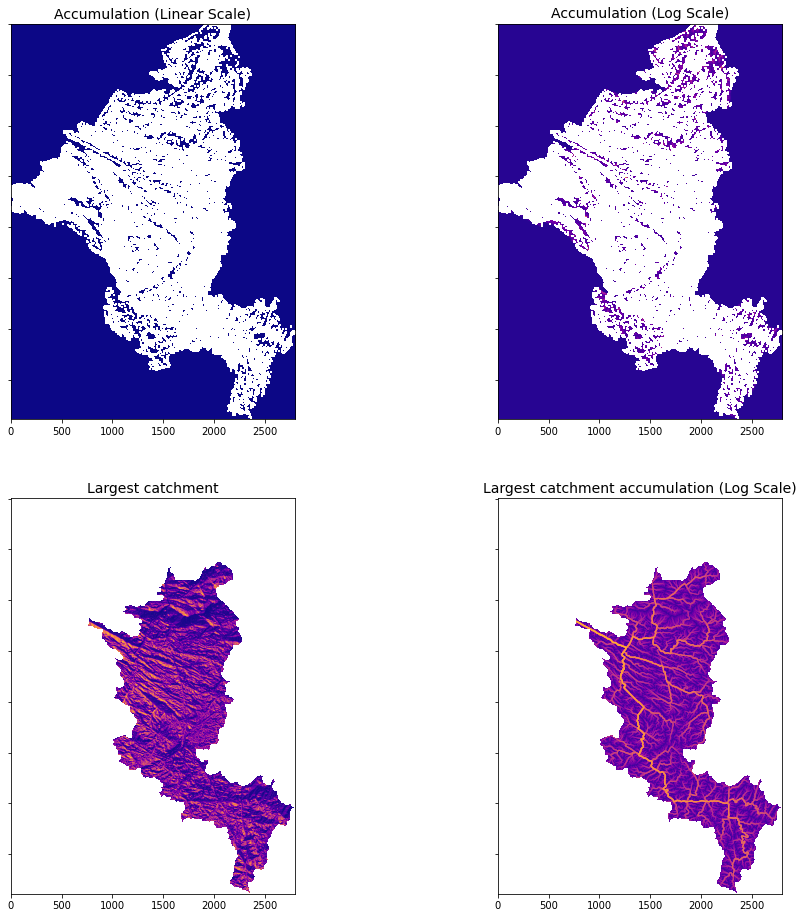

In [ ]:
# Plot accumulation and catchment
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0,0].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma')
ax[0,1].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))
ax[1,0].imshow(np.where(grid.catch, grid.catch, np.nan), zorder=1, cmap='plasma')
ax[1,1].imshow(np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))

ax[0,0].set_title('Accumulation (Linear Scale)', size=14)
ax[0,1].set_title('Accumulation (Log Scale)', size=14)
ax[1,0].set_title('Largest catchment', size=14)
ax[1,1].set_title('Largest catchment accumulation (Log Scale)', size=14)

for i in range(ax.size):
    ax.flat[i].set_yticklabels([])

In [ ]:
new = np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',norm=colors.LogNorm(vmin=1, vmax=grid.acc.max())

SyntaxError: ignored

In [ ]:
streams_new = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
streams["features"][:2]

SyntaxError: ignored

In [ ]:
import mplleaflet
import matplotlib.pyplot as plt

lats = [54.3256, 53.2692, 53.8242, 53.2178]
lons = [2.9356, 3.6278, 2.9453, 3.2203] 

fig = plt.figure()    #This is missing in your code.
plt.plot(lons, lats, 'r.')

#And after this call the funtion:

mplleaflet.display(fig=fig)
#It will display the matplotlib object created by plot function

In [ ]:
import pandas as pd
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from functools import partial

WGS84 = pyproj.Proj('epsg:4326')

def latlonbuffer(lat, lon, radius_m):
    proj4str = '+proj=aeqd +lat_0=%s +lon_0=%s +x_0=0 +y_0=0' % (lat, lon)
    AEQD = pyproj.Proj(proj4str) # azimuthal equidistant
    project = partial(pyproj.transform, AEQD, WGS84)
    return transform(project, Point(0, 0).buffer(radius_m))

In [ ]:
geometry, centroid
POLYGON((26.48306 50.09625, 26.47916 50.09604..), ((26.48307336330026, 50.052005610561245))

SyntaxError: ignored